In [1]:
import torch
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
# === Load trained model and scalers ===
input_scaler = joblib.load("apogee_input_scaler.pkl")
target_scaler = joblib.load("apogee_target_scaler.pkl")

class ApogeeMLP(torch.nn.Module):
    def __init__(self, input_dim):
        super(ApogeeMLP, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Load model weights
model = ApogeeMLP(input_dim=400)  # adjust if your input shape differs
model.load_state_dict(torch.load("apogee_mlp_model.pth"))
model.eval()

ApogeeMLP(
  (model): Sequential(
    (0): Linear(in_features=400, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [3]:
# === Load the dataset ===
df = pd.read_csv("sliding_test_by_flight.csv")
X = df.drop(columns=["Apogee"]).values
y_true = df["Apogee"].values.reshape(-1, 1)

# Scale inputs
X_scaled = input_scaler.transform(X)

In [5]:
# Predict with the model
with torch.no_grad():
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_pred_scaled = model(X_tensor).numpy()

# Unscale predicted apogees
y_pred = target_scaler.inverse_transform(y_pred_scaled)

# === Evaluation ===
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} meters")

RMSE: 6.61 meters


In [6]:
# Optionally inspect a few predictions
for i in range(5):
    print(f"Sample {i+1}: Predicted = {y_pred[i][0]:.2f} m, True = {y_true[i][0]:.2f} m")

Sample 1: Predicted = 3089.44 m, True = 3047.79 m
Sample 2: Predicted = 3076.10 m, True = 3047.79 m
Sample 3: Predicted = 3079.88 m, True = 3047.79 m
Sample 4: Predicted = 3074.77 m, True = 3047.79 m
Sample 5: Predicted = 3068.57 m, True = 3047.79 m


In [7]:
# Show predictions for just one unique true apogee (i.e., one flight)
target_apogee = y_true[0][0]  # pick the first flight
indices = np.where(np.isclose(y_true, target_apogee, atol=0.01))[0]

print(f"\n=== Predictions for Flight with True Apogee ≈ {target_apogee:.2f} m ===")
for i in indices[:20]:  # limit to 20
    print(f"Sample {i}: Pred = {y_pred[i][0]:.2f} m, True = {y_true[i][0]:.2f} m")



=== Predictions for Flight with True Apogee ≈ 3047.79 m ===
Sample 0: Pred = 3089.44 m, True = 3047.79 m
Sample 1: Pred = 3076.10 m, True = 3047.79 m
Sample 2: Pred = 3079.88 m, True = 3047.79 m
Sample 3: Pred = 3074.77 m, True = 3047.79 m
Sample 4: Pred = 3068.57 m, True = 3047.79 m
Sample 5: Pred = 3061.30 m, True = 3047.79 m
Sample 6: Pred = 3054.68 m, True = 3047.79 m
Sample 7: Pred = 3049.74 m, True = 3047.79 m
Sample 8: Pred = 3049.52 m, True = 3047.79 m
Sample 9: Pred = 3049.85 m, True = 3047.79 m
Sample 10: Pred = 3050.47 m, True = 3047.79 m
Sample 11: Pred = 3050.70 m, True = 3047.79 m
Sample 12: Pred = 3050.48 m, True = 3047.79 m
Sample 13: Pred = 3050.38 m, True = 3047.79 m
Sample 14: Pred = 3050.21 m, True = 3047.79 m
Sample 15: Pred = 3049.88 m, True = 3047.79 m
Sample 16: Pred = 3049.91 m, True = 3047.79 m
Sample 17: Pred = 3050.47 m, True = 3047.79 m
Sample 18: Pred = 3050.93 m, True = 3047.79 m
Sample 19: Pred = 3051.25 m, True = 3047.79 m


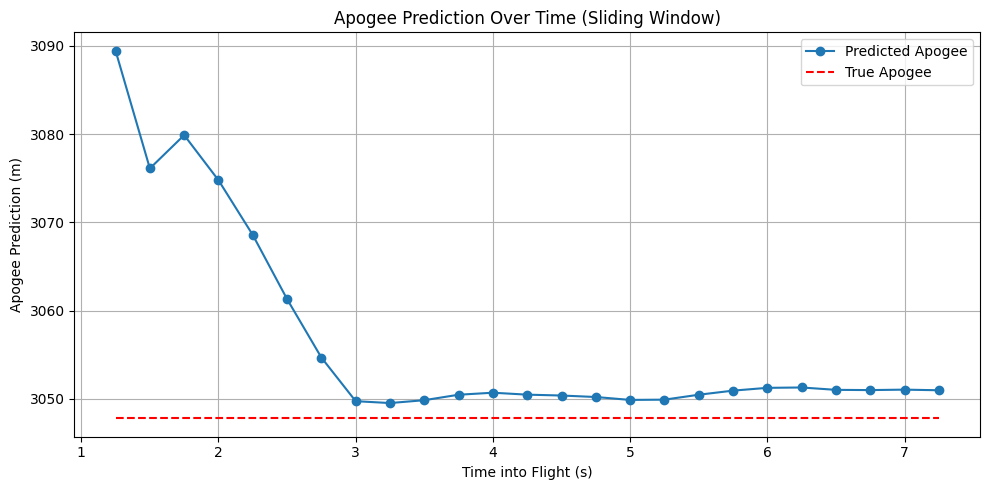

In [15]:
import matplotlib.pyplot as plt
import numpy as np

#df_full = pd.read_csv("batch_dataset_v1.csv")

# Choose the Nth row (flight) from the original unwindowed data
flight_index = 0  # change this if needed
target_apogee = df.iloc[flight_index]["Apogee"]

# Compute time 
timestep_interval = 0.025
window_size = int(2.5 / timestep_interval)
stride = int(0.25 / timestep_interval)

# Use df_full as your unwindowed data (1 row per flight)
#num_flights = len(df_full)
#samples_per_flight = len(df) // num_flights

samples_per_flight = ((25 / timestep_interval - window_size) // stride) + 1
samples_per_flight = int(samples_per_flight)  # Should be 91
samples_per_flight = 25

# Get the window range for that one flight
start = flight_index * samples_per_flight
end = start + samples_per_flight

# Slice predictions and true values
preds = y_pred[start:end].flatten()
true_vals = y_true[start:end].flatten()

time = np.array([((i * stride) + window_size // 2) * timestep_interval for i in range(len(preds))])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, preds, label='Predicted Apogee', marker='o')
plt.hlines(target_apogee, time[0], time[-1], colors='r', linestyles='--', label='True Apogee')

plt.title("Apogee Prediction Over Time (Sliding Window)")
plt.xlabel("Time into Flight (s)")
plt.ylabel("Apogee Prediction (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
